# Qutip project 7

For more information about QuTiP see [http://qutip.org](http://qutip.org)

Revised by A.S. Ivlev

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from qutip import *

# Introduction

Hyperfine interaction starts to play a role when the spatial extent of the wavefunctions is significant. For example, an electron spin orbiting a nucleus experience a hyperfine interaction due to the nuclear spin. This impacts the energy of the electron spin. In this notebook, we are going to simulate observations made by Hanson et al. in PhysRevLett.97.087601, where hyperfine interaction plays a significant role in the dynamics of their NV-center experiment.  

## Definition of the system

In [12]:
# S=1 matrices
sTx = Qobj(np.array([[ 0, 1, 0],
                     [ 1, 0, 1],
                     [ 0, 1, 0]]))/(np.sqrt(2))
sTy = Qobj(np.array([[ 0, 1, 0],
                     [-1, 0, 1],
                     [ 0,-1, 0]]))/(np.sqrt(2)*1j)
sTz = Qobj(np.array([[1, 0, 0],
                     [0, 0, 0],
                     [0, 0,-1]]))

In [13]:
# operators for spin NV (S=1)

s0x = tensor(sTx, qeye(2), qeye(3))
s0y = tensor(sTy, qeye(2), qeye(3))
s0z = tensor(sTz, qeye(2), qeye(3))


# operators for spin N (nitrogen electron S=1/2)
s1x = tensor(qeye(3), sigmax()/2, qeye(3))
s1y = tensor(qeye(3), sigmay()/2, qeye(3))
s1z = tensor(qeye(3), sigmaz()/2, qeye(3))

# operators for spin I (nitrogen nuclei S=1)
s2x = tensor(qeye(3), qeye(2), sTx)
s2y = tensor(qeye(3), qeye(2), sTy)
s2z = tensor(qeye(3), qeye(2), sTz)


In [14]:
def system_Hamiltonian(B = 514e-4, A = 86e6, theta=54.7):
    # B: Magnetic field in Tesla
    # A (Hz): Hyperfine constant. The value depends on magnetic field angle with respect to four C-atoms around N atom (N atom of the NV center).
    
    # Hamiltonian based on: PhysRevLett.97.087601
    # The hyperfine couplings between NV center spin and nitrogen nuclei is neglected
    
    
    eCharge = 1.609e-19
    hbar2pi = 6.62e-34
    uB = 57.88e-6   # Bohr magnetion. unit: eV
    gN, gNV = 2, 2   # electron g-factor
    D = 2.88e9  # zero-field splitting. unit: Hz
    B0 = gNV*uB*B *eCharge/(hbar2pi)  # Zeeman splitting energy of NV electron. unit: Hz
    B1 = gN*uB*B *eCharge/(hbar2pi)  # Zeeman splitting energy of N electron. unit: Hz

    r = 2e-9 #Radius between NV center electron to N electron [meter]
    theta = theta # Angle [degrees] between NV center electron and N electron in the z-x plane
    x, y, z = r*np.sin(-np.pi*theta/180), 0, r*np.cos(np.pi*theta/180)   # position vector from NV center electron to N electron. unit: meter
    Mrr = np.kron(np.array([x, y, z]), np.array([[x], [y], [z]]))/(r**2)
    J = (np.eye(3) - 3*Mrr) * 1e-7*gNV*gN*(uB**2 * eCharge**2)/(r**3 * hbar2pi)  # dipolar coupling coefficients between electrons of NV and N (fine-structure tensor)
    H_NV = D* (s0z*s0z - (1/3)*(s0x*s0x+s0y*s0y+s0z*s0z)) + B0*s0z
    H_N = B1*s1z + A*(s1x*s2x + s1y*s2y + s1z*s2z)
    H_dip = s0x*s1x*J[0,0] + s0x*s1y*J[0,1] + s0x*s1z*J[0,2] \
            + s0y*s1x*J[1,0] + s0y*s1y*J[1,1] + s0y*s1z*J[1,2] \
            + s0z*s1x*J[2,0] + s0z*s1y*J[2,1] + s0z*s1z*J[2,2]

    H = H_NV + H_N + H_dip
    
    return H

In [28]:
def qubit_integrate(B,A,theta,psi0,t_list, solver, g1 = 0):

    H0 = system_Hamiltonian(B=B,A=A,theta=theta)
    
    H = H0
        
    # collapse operators
    c_ops = []

    if g1 > 0.0:
        polarising_Laser = tensor(Qobj(np.array([[0, 0,0],
                          [1, 1,1],[0,0,0]])), qeye(2), qeye(3))
        c_ops.append(np.sqrt(g1) * polarising_Laser)
        polarising_Laser = tensor(Qobj(np.array([[0, 0,0],
                          [1j, 1j,1j],[0,0,0]])), qeye(2), qeye(3))
        c_ops.append(np.sqrt(g1) * polarising_Laser)
    
    g2 = 1e6 ### Some dephasing is introduced, to reduce coherent bevahiour, and focus on polarization transfer
    c_ops.append(np.sqrt(g2) * tensor(sTz, sigmaz(), sTz))


    e_ops = [s0x, s0y, s0z,s1x, s1y, s1z,s2x, s2y, s2z]
        
    if solver == "me":
        output = mesolve(H, psi0, tlist, c_ops, e_ops)  
    elif solver == "es":
        output = essolve(H, psi0, tlist, c_ops, e_ops)  
    elif solver == "mc":
        ntraj = 250
        output = mcsolve(H, psi0, tlist, c_ops, e_ops,ntraj=ntraj)  
    else:
        raise ValueError("unknown solver")

    pauli_0 = (output.expect[0], output.expect[1], output.expect[2])
    pauli_1 = (output.expect[3], output.expect[4], output.expect[5])
    pauli_2 = (output.expect[6], output.expect[7], output.expect[8])
    return pauli_0, pauli_1, pauli_2

## Energy Levels

Below you can track the energy level of the NV system, as function of the magnetic field. Each field-dependent line is split, corresponding to a combination of NV and N electron spin is split due to the hyperfine interection between the N electron and the N nucleus. Increase $A$ to increase this splitting. As we zoom in on the point where the (-1,+1/2) and (0,-1/2) states, where (NV_ele,N_ele) are the spin states for the electron in the NV and the nitrogen nucleus, we see the some anticrossing as a result of the dipolar interaction. At the 'magic angle' of theta=54.7 deg this interaction leads to hybridization of the spin states, effectively leading to a flip-flop interaction between the electron spin states.

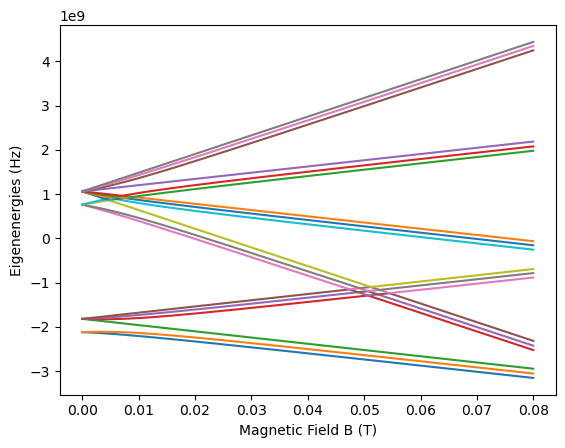

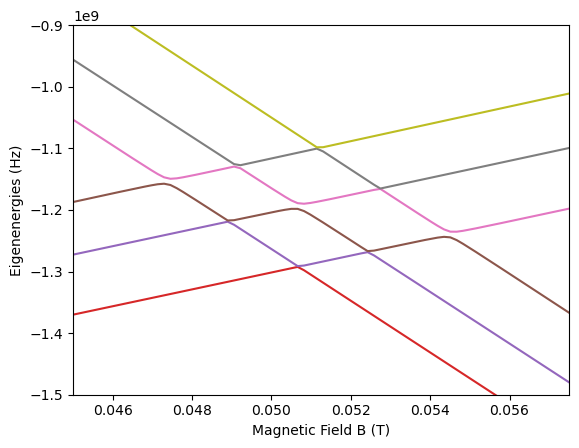

In [16]:
B_list = np.linspace(0e-4,800e-4,500) # Magnetic Field in Tesla
theta = 54.7 # Angle between the N and NV electrons, relative to the magnetic field.  Degrees
A = 200e6 # Hyperfine splitting energy. Hz
energy_list = []
for B in B_list:
    energy_at_field = system_Hamiltonian(B,A=A,theta = theta).eigenenergies()
    energy_list.append(energy_at_field)

plt.plot(B_list,energy_list)
plt.ylabel('Eigenenergies (Hz)')
plt.xlabel('Magnetic Field B (T)')
plt.show()
plt.figure()
plt.plot(B_list,energy_list)
plt.ylabel('Eigenenergies (Hz)')
plt.xlabel('Magnetic Field B (T)')
plt.xlim(0.045,0.0575)
plt.ylim((-1.5e9,-0.9e9))
plt.show()

## Polarization of the NV Spin
Due to the hybridization at the avoided crossing, flip-flop interaction transfers the spin-state from the NV electron spin to the N electron spin. This is observed as we try to polarize the NV electron to the Spin 0 state for a particular time. Experimentally this polarization is typically done with a laser. 
The flip-flop interaction will counter-act the polarization, and leads to a higher population in the -1 spin mixture of the NV electron, as we see below. For simplicity, we exclude the hyperfine interaction here. 
Since this flip-flop interaction only occurs at the 'magic angle', and particular magnetic field, we can observe the field depedence, which we'll see below. 

This also depends on the angle $\theta$, as that dictates the flip-flop interaction!

Note: This field dependent simulation takes some time. The resolution is relatively low to speed it up a bit.

In [52]:
A = 0*86e6
B_list = np.linspace(460e-4,560e-4,50)
theta = 54.7

rho0 = tensor( qeye(3)/3, qeye(2)/2,qeye(3)/2 ) # Initialising in a maximally mixed state
g1 = 1e6 #Rate of the polarization due to the 'laser'

tlist = np.linspace(0,1/g1/2,1000) #Time the 'laser' is applied

pol_NV_all = np.zeros(B_list.size)
pol_N_ele_all = np.zeros(B_list.size)
pol_N_nuc_all = np.zeros(B_list.size)

for idx,B in enumerate(B_list):
    expect_0, expect_1, expect_2 = qubit_integrate(B, A,theta,rho0,tlist, "me",g1)
    pol_NV = expect_0[2][-1]
    pol_N_ele = expect_1[2][-1]
    pol_N_nuc = expect_2[2][-1]
    
    pol_NV_all[idx] = pol_NV
    pol_N_ele_all[idx] = pol_N_ele
    pol_N_nuc_all[idx] = pol_N_nuc
    
    if (idx+1) % 5==0:
        print(f'Field dependent simulation at {100*(idx+1)/B_list.size}%')



Field dependent simulation at 10.0%
Field dependent simulation at 20.0%
Field dependent simulation at 30.0%
Field dependent simulation at 40.0%
Field dependent simulation at 50.0%
Field dependent simulation at 60.0%
Field dependent simulation at 70.0%
Field dependent simulation at 80.0%
Field dependent simulation at 90.0%
Field dependent simulation at 100.0%


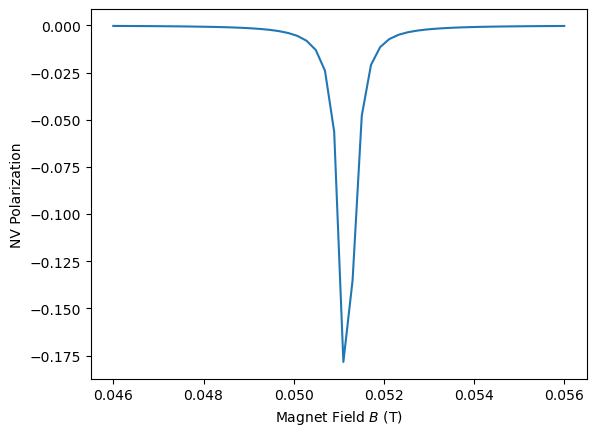

In [53]:
plt.plot(B_list,pol_NV_all)
plt.xlabel('Magnet Field $B$ (T)')
plt.ylabel('NV Polarization')

plt.show()

## Effect of Nuclear Polarization
Now let us reintroduce the hyperfine interaction. We will see that the electron energies are split due to the hyperfine interaction, and hence the resonant energy of the (-1,1/2)-(0,-1/2) electron-spin transition has changed. In particular the polarization rate of the NV electron is now decreased at three different magnetic fields (at which the flip-flop interaction takes place). This is seen in the code below.

What happens if the nuclear spin is polarized? Change the density matrix corresponding to the nuclear spin, and polarize it somewhat (e.g. Qobj(np.array([[0.7, 0, 0],[0, 1, 0],[0, 0, 1.2]])/3)

Notice that the peaks change height correspondingly, as is observed in the paper by Hanson et al. Depending on the polarization of the nuclear spin, some transitions are available or not! One can use this to read out the spin-state of the nuclear spin. As hypothesised by Hanson et al. the nuclear spin is initially due to the hyperfine interaction between the electron and nuclear spin. This would imply possible control over the nuclear spin, which is crucial if we want to use it as a qubit. Control over the nuclear spin using this hyperfine interaction has indeed been shown (e.g. Bradley et al. Phys. Rev. X 9, 031045)


In [54]:
A = 86e6
B_list = np.linspace(480e-4,550e-4,50)
theta = 54.7 # In degress

###
### Initialising in a maximally mixed state
rho0 = tensor( qeye(3)/3, qeye(2)/2,qeye(3)/2 ) 
###
# ###
# ### Initialising in a slightly polarised state
# rho0 = tensor( qeye(3)/3, qeye(2)/2,Qobj(np.array([[0.7, 0, 0],[0, 1, 0],[0, 0, 1.2]])/3 )) 
# ###

g1 = 1e6 #Rate of the polarization due to the 'laser'

tlist = np.linspace(0,1/g1/2,1000) #Time the 'laser' is applied

pol_NV_all = np.zeros(B_list.size)
pol_N_ele_all = np.zeros(B_list.size)
pol_N_nuc_all = np.zeros(B_list.size)

for idx,B in enumerate(B_list):
    expect_0, expect_1, expect_2 = qubit_integrate(B, A,theta,rho0,tlist, "me",g1)
    pol_NV = expect_0[2][-1]
    pol_N_ele = expect_1[2][-1]
    pol_N_nuc = expect_2[2][-1]
    
    pol_NV_all[idx] = pol_NV
    pol_N_ele_all[idx] = pol_N_ele
    pol_N_nuc_all[idx] = pol_N_nuc
    
    if (idx+1) % 5==0:
        print(f'Field dependent simulation at {100*(idx+1)/B_list.size}%')



Field dependent simulation at 10.0%
Field dependent simulation at 20.0%
Field dependent simulation at 30.0%
Field dependent simulation at 40.0%
Field dependent simulation at 50.0%
Field dependent simulation at 60.0%
Field dependent simulation at 70.0%
Field dependent simulation at 80.0%
Field dependent simulation at 90.0%
Field dependent simulation at 100.0%


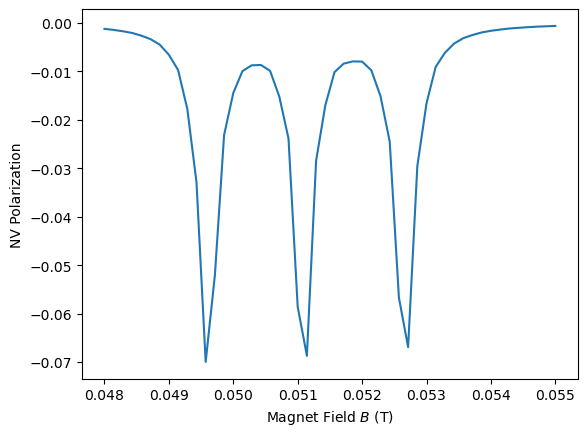

In [55]:
plt.plot(B_list,pol_NV_all)
plt.xlabel('Magnet Field $B$ (T)')
plt.ylabel('NV Polarization')

plt.show()